In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter
from AnchorOptimalProjector import *
from MVA_algo import ReducedRankRegressor

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [3]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/', coarse=12, window_size=10):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        tas_regional = tas_array.reshape(shape[0], shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse)
        X_temp = tas_regional.mean(axis=(3, 5))
        rmt = X_temp.mean(axis=0)
        # Calculate regional internal variability
        riv = rmt - X_temp
        # Create a 1D convolution kernel for the moving average
        kernel = np.ones(window_size) / window_size
        # Smooth the regional internal variability using a moving average
        A_temp = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=riv)
            
            
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)).reshape(shape[0]*shape[1], shape[2]*shape[3])
        A_temp = A_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
            A = A_temp[idxs, :] 
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
            A = np.vstack((A, A_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
        del A_temp
    return A, X, y

In [4]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [11]:
B = 12
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [14]:
occurence_models_test = Counter(models_test)
occurence_models_test

Counter({'MIROC6': 2, 'CESM2': 2, 'MPI-ESM1-2-LR': 5, 'MIROC-ES2L': 3})

In [15]:
N = 100
n_alpha = 10
alphas = np.logspace(1, 3, n_alpha)
coarse = 36
n_cv = 3
gammas = [1, 2, 5]

In [17]:
try :
    directory = '../weights/'
    file = 'Anchor_RRRR_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
    with open(directory + file, 'rb') as f:
        weights = pickle.load(f)
except:
    print('Weights does not exists!')
    weights = {model:{gamma : {'weights':None, 'n_samples': N*occurence_models_test[model]} for gamma in gammas} for model in models}
    
for model in models : 
    for gamma in gammas :
        if gamma not in weights[model].keys():
            weights[model][gamma]['weights'] = None
            weights[model][gamma]['n_samples'] = N*occurence_models_test[model]

Weights does not exists!


In [18]:
weights

{'CanESM5': {1: {'weights': None, 'n_samples': 0},
  2: {'weights': None, 'n_samples': 0},
  5: {'weights': None, 'n_samples': 0}},
 'MIROC-ES2L': {1: {'weights': None, 'n_samples': 300},
  2: {'weights': None, 'n_samples': 300},
  5: {'weights': None, 'n_samples': 300}},
 'MPI-ESM1-2-LR': {1: {'weights': None, 'n_samples': 500},
  2: {'weights': None, 'n_samples': 500},
  5: {'weights': None, 'n_samples': 500}},
 'MIROC6': {1: {'weights': None, 'n_samples': 200},
  2: {'weights': None, 'n_samples': 200},
  5: {'weights': None, 'n_samples': 200}},
 'CESM2': {1: {'weights': None, 'n_samples': 200},
  2: {'weights': None, 'n_samples': 200},
  5: {'weights': None, 'n_samples': 200}}}

In [23]:
ranks = np.arange(100, 1000, 200)
regs = np.logspace(1, 4, 5)
hyperparameters = [(rank, reg) for rank in ranks for reg in regs]
print(len(hyperparameters))

25


In [11]:

for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    #print('Fitting optimal ridge {}/{}'.format(i, B))
    print("Extracting data...", end='\r')
    A_train, X_train, Y_train = load_data_models(m_train, n_sample=N, coarse=coarse)
    print("Data extracted!")
    
    
    print('Transform training data with AOP...', end='\r')
    AOP = AnchorOptimalProjection(gamma=gammas)
    X_trains, Y_trains = AOP.fit_transform(A_train, X_train, Y_train)
    print('Data transformed!')
    
    for gamma in gammas:
        print(r"Training anchor ($\gamma$={:.1f})...".format(gamma), end='\r')
        score = -np.Inf
        rrr = None
        for alpha, rank in hyperparameters:
            # training reduce rank regression
            rrr_temp = ReducedRankRegressor(reg=alpha, rank=rank) #cv=zip(idx_val, idx_val))
            rrr_temp.fit(X_trains[gamma], Y_trains[gamma])
            score_temp = rrr_temp.score(X_val, Y_val)
            if score_temp>score:
                score = score_temp
                rrr = rrr_temp
            
            
        print('Selected alpha : {}'.format(rank_opt))
        print('Selected rank : {}'.format(rrr.alpha_))
        print("Ridge regression fitted!")
        print('Saving weights...', end='\r')
        if weights[m_test][gamma]['weights'] is None:
            weights[m_test][gamma]['weights'] = np.hstack((rrr.coef_, rrr.intercept_[:,None]))
        else:
            weights[m_test][gamma]['weights'] = (weights[m_test][gamma]['n_samples']*weights[m_test][gamma]['weights'] + N*occurence_models_test[m_test]*np.hstack((ridge.coef_, ridge.intercept_[:,None])))/(N*occurence_models_test[m_test] + weights[m_test][gamma]['n_samples'])
            weights[m_test][gamma]['n_samples'] += N*occurence_models_test[m_test]
        print("Weights saved!")
# Save the weights for this alpha to a file
file_path = f'../weights/Anchor_RRRR_weights_stability_n{N}_coarse{coarse}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)

  0%|          | 0/200 [00:00<?, ?it/s]

Data extracted!
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


  0%|          | 1/200 [01:27<4:51:28, 87.88s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


  1%|          | 2/200 [03:02<5:03:19, 91.92s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


  2%|▏         | 3/200 [04:13<4:30:04, 82.26s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


  2%|▏         | 4/200 [05:37<4:31:06, 82.99s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


  2%|▎         | 5/200 [07:02<4:31:52, 83.65s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


  3%|▎         | 6/200 [08:47<4:53:44, 90.85s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


  4%|▎         | 7/200 [10:35<5:11:09, 96.73s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


  4%|▍         | 8/200 [12:09<5:06:15, 95.70s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


  4%|▍         | 9/200 [13:36<4:55:57, 92.97s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


  5%|▌         | 10/200 [15:20<5:05:23, 96.44s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


  6%|▌         | 11/200 [17:04<5:10:51, 98.68s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


  6%|▌         | 12/200 [18:27<4:54:11, 93.89s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


  6%|▋         | 13/200 [20:17<5:07:55, 98.80s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


  7%|▋         | 14/200 [22:10<5:19:42, 103.13s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...


  8%|▊         | 15/200 [24:07<5:30:36, 107.22s/it]

Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


  8%|▊         | 16/200 [25:31<5:07:35, 100.30s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


  8%|▊         | 17/200 [26:59<4:54:11, 96.45s/it] 

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


  9%|▉         | 18/200 [28:38<4:55:43, 97.49s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 10%|▉         | 19/200 [30:13<4:51:51, 96.75s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 10%|█         | 20/200 [32:09<5:07:08, 102.38s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 10%|█         | 21/200 [33:36<4:51:49, 97.82s/it] 

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 11%|█         | 22/200 [35:19<4:54:35, 99.30s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 12%|█▏        | 23/200 [37:20<5:12:16, 105.86s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 12%|█▏        | 24/200 [39:18<5:21:07, 109.47s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 12%|█▎        | 25/200 [40:59<5:12:16, 107.07s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 13%|█▎        | 26/200 [42:42<5:06:43, 105.77s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 14%|█▎        | 27/200 [44:02<4:42:34, 98.00s/it] 

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 14%|█▍        | 28/200 [46:10<5:06:55, 107.07s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 14%|█▍        | 29/200 [48:40<5:41:48, 119.93s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 15%|█▌        | 30/200 [50:52<5:49:34, 123.38s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 16%|█▌        | 31/200 [52:44<5:38:30, 120.18s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 16%|█▌        | 32/200 [54:22<5:17:30, 113.40s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 16%|█▋        | 33/200 [56:05<5:07:01, 110.31s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 17%|█▋        | 34/200 [57:51<5:01:14, 108.88s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 18%|█▊        | 35/200 [59:24<4:46:45, 104.28s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 18%|█▊        | 36/200 [1:00:55<4:34:24, 100.39s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 18%|█▊        | 37/200 [1:02:46<4:40:49, 103.37s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 19%|█▉        | 38/200 [1:04:27<4:37:05, 102.63s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 20%|█▉        | 39/200 [1:06:05<4:32:17, 101.47s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 20%|██        | 40/200 [1:07:49<4:31:54, 101.97s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 20%|██        | 41/200 [1:09:24<4:24:43, 99.89s/it] 

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 21%|██        | 42/200 [1:10:50<4:12:22, 95.84s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 22%|██▏       | 43/200 [1:12:15<4:02:02, 92.50s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 22%|██▏       | 44/200 [1:13:32<3:48:38, 87.94s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 22%|██▎       | 45/200 [1:14:57<3:45:01, 87.10s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 23%|██▎       | 46/200 [1:16:21<3:41:05, 86.14s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 24%|██▎       | 47/200 [1:17:40<3:34:15, 84.02s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 24%|██▍       | 48/200 [1:18:58<3:27:49, 82.04s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 24%|██▍       | 49/200 [1:20:21<3:27:17, 82.37s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 25%|██▌       | 50/200 [1:21:51<3:31:57, 84.78s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 26%|██▌       | 51/200 [1:23:13<3:28:38, 84.02s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 26%|██▌       | 52/200 [1:24:38<3:27:39, 84.18s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 26%|██▋       | 53/200 [1:26:00<3:24:26, 83.45s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 27%|██▋       | 54/200 [1:27:27<3:25:54, 84.62s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 28%|██▊       | 55/200 [1:28:44<3:18:52, 82.29s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 28%|██▊       | 56/200 [1:30:13<3:22:44, 84.47s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 28%|██▊       | 57/200 [1:31:42<3:24:30, 85.81s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 29%|██▉       | 58/200 [1:33:01<3:18:08, 83.72s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 30%|██▉       | 59/200 [1:34:22<3:14:34, 82.80s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 30%|███       | 60/200 [1:35:38<3:08:49, 80.92s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 30%|███       | 61/200 [1:36:56<3:05:02, 79.87s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 31%|███       | 62/200 [1:38:23<3:08:38, 82.02s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 32%|███▏      | 63/200 [1:39:50<3:10:30, 83.43s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 32%|███▏      | 64/200 [1:41:15<3:10:14, 83.93s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 32%|███▎      | 65/200 [1:42:28<3:01:34, 80.70s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 33%|███▎      | 66/200 [1:43:44<2:56:55, 79.22s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 34%|███▎      | 67/200 [1:45:05<2:56:52, 79.79s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 34%|███▍      | 68/200 [1:46:27<2:57:00, 80.46s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 34%|███▍      | 69/200 [1:47:49<2:57:00, 81.07s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 35%|███▌      | 70/200 [1:49:05<2:52:03, 79.41s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 36%|███▌      | 71/200 [1:50:27<2:52:23, 80.18s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 36%|███▌      | 72/200 [1:51:44<2:49:02, 79.24s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 36%|███▋      | 73/200 [1:53:06<2:49:25, 80.04s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 37%|███▋      | 74/200 [1:54:28<2:49:16, 80.61s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 38%|███▊      | 75/200 [1:55:44<2:45:02, 79.22s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 38%|███▊      | 76/200 [1:57:12<2:49:14, 81.89s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 38%|███▊      | 77/200 [1:58:32<2:47:06, 81.52s/it]

Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 39%|███▉      | 78/200 [1:59:58<2:48:19, 82.78s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 40%|███▉      | 79/200 [2:00:51<2:29:06, 73.94s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 40%|████      | 80/200 [2:01:53<2:20:39, 70.33s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 40%|████      | 81/200 [2:03:12<2:24:23, 72.80s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 41%|████      | 82/200 [2:04:24<2:22:43, 72.57s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 42%|████▏     | 83/200 [2:05:35<2:20:31, 72.06s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 42%|████▏     | 84/200 [2:06:43<2:17:17, 71.01s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 42%|████▎     | 85/200 [2:07:59<2:18:40, 72.35s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 43%|████▎     | 86/200 [2:09:11<2:17:07, 72.17s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 44%|████▎     | 87/200 [2:10:28<2:18:42, 73.65s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 44%|████▍     | 88/200 [2:11:32<2:12:27, 70.96s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 44%|████▍     | 89/200 [2:12:37<2:07:41, 69.03s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 45%|████▌     | 90/200 [2:13:42<2:04:10, 67.73s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 46%|████▌     | 91/200 [2:14:50<2:03:10, 67.81s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...


 46%|████▌     | 92/200 [2:16:08<2:07:33, 70.87s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 46%|████▋     | 93/200 [2:17:45<2:20:23, 78.72s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 47%|████▋     | 94/200 [2:18:46<2:09:59, 73.58s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 48%|████▊     | 95/200 [2:19:46<2:01:43, 69.56s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 48%|████▊     | 96/200 [2:20:49<1:56:57, 67.48s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 48%|████▊     | 97/200 [2:23:01<2:29:14, 86.94s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 49%|████▉     | 98/200 [2:24:32<2:29:40, 88.04s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 50%|████▉     | 99/200 [2:26:17<2:37:00, 93.28s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 50%|█████     | 100/200 [2:28:23<2:51:44, 103.05s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 50%|█████     | 101/200 [2:30:00<2:46:46, 101.08s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 51%|█████     | 102/200 [2:31:09<2:29:31, 91.55s/it] 

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 52%|█████▏    | 103/200 [2:32:11<2:13:26, 82.54s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 52%|█████▏    | 104/200 [2:33:10<2:00:44, 75.46s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 52%|█████▎    | 105/200 [2:34:07<1:51:07, 70.19s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 53%|█████▎    | 106/200 [2:35:08<1:45:21, 67.25s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 54%|█████▎    | 107/200 [2:36:05<1:39:29, 64.19s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 54%|█████▍    | 108/200 [2:37:05<1:36:35, 63.00s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 55%|█████▍    | 109/200 [2:38:02<1:32:48, 61.20s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 55%|█████▌    | 110/200 [2:38:58<1:29:25, 59.61s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 56%|█████▌    | 111/200 [2:39:57<1:27:57, 59.29s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 56%|█████▌    | 112/200 [2:40:57<1:27:23, 59.59s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 56%|█████▋    | 113/200 [2:41:57<1:26:49, 59.88s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 57%|█████▋    | 114/200 [2:42:58<1:26:05, 60.06s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 57%|█████▊    | 115/200 [2:44:00<1:25:50, 60.59s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 58%|█████▊    | 116/200 [2:45:01<1:24:58, 60.70s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 58%|█████▊    | 117/200 [2:46:03<1:24:48, 61.31s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 59%|█████▉    | 118/200 [2:46:59<1:21:22, 59.55s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 60%|█████▉    | 119/200 [2:47:55<1:19:00, 58.52s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 60%|██████    | 120/200 [2:48:53<1:17:45, 58.32s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 60%|██████    | 121/200 [2:49:51<1:16:55, 58.42s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 61%|██████    | 122/200 [2:50:47<1:14:58, 57.68s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 62%|██████▏   | 123/200 [2:51:46<1:14:14, 57.85s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 62%|██████▏   | 124/200 [2:52:43<1:13:00, 57.64s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 62%|██████▎   | 125/200 [2:53:40<1:11:50, 57.47s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 63%|██████▎   | 126/200 [2:54:37<1:10:44, 57.36s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 64%|██████▎   | 127/200 [2:55:39<1:11:18, 58.61s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 64%|██████▍   | 128/200 [2:56:38<1:10:45, 58.97s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 64%|██████▍   | 129/200 [2:57:44<1:11:59, 60.84s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 65%|██████▌   | 130/200 [2:58:45<1:11:07, 60.97s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 66%|██████▌   | 131/200 [2:59:51<1:11:53, 62.51s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 66%|██████▌   | 132/200 [3:01:17<1:18:52, 69.59s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 66%|██████▋   | 133/200 [3:02:29<1:18:29, 70.30s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 67%|██████▋   | 134/200 [3:03:38<1:16:56, 69.94s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...


 68%|██████▊   | 135/200 [3:04:44<1:14:23, 68.67s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 68%|██████▊   | 136/200 [3:05:48<1:11:52, 67.38s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 68%|██████▊   | 137/200 [3:07:07<1:14:29, 70.95s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 69%|██████▉   | 138/200 [3:08:29<1:16:28, 74.01s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 70%|██████▉   | 139/200 [3:09:43<1:15:19, 74.09s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 70%|███████   | 140/200 [3:11:04<1:16:20, 76.35s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 70%|███████   | 141/200 [3:12:10<1:11:57, 73.18s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 71%|███████   | 142/200 [3:13:21<1:09:59, 72.41s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 72%|███████▏  | 143/200 [3:14:14<1:03:21, 66.69s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 72%|███████▏  | 144/200 [3:15:29<1:04:31, 69.14s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 72%|███████▎  | 145/200 [3:16:37<1:03:02, 68.77s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 73%|███████▎  | 146/200 [3:17:58<1:05:13, 72.48s/it]

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 74%|███████▎  | 147/200 [3:19:09<1:03:31, 71.91s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 74%|███████▍  | 148/200 [3:20:22<1:02:34, 72.19s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...


 74%|███████▍  | 149/200 [3:21:49<1:05:10, 76.68s/it]

Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 75%|███████▌  | 150/200 [3:22:54<1:01:07, 73.36s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 76%|███████▌  | 151/200 [3:25:48<1:24:25, 103.38s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 76%|███████▌  | 152/200 [3:26:44<1:11:26, 89.30s/it] 

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 76%|███████▋  | 153/200 [3:27:49<1:04:08, 81.89s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 77%|███████▋  | 154/200 [3:28:50<58:06, 75.78s/it]  

Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 78%|███████▊  | 155/200 [3:29:55<54:21, 72.48s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 78%|███████▊  | 156/200 [3:30:55<50:22, 68.69s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 78%|███████▊  | 157/200 [3:31:59<48:10, 67.22s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 79%|███████▉  | 158/200 [3:32:58<45:23, 64.86s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 80%|███████▉  | 159/200 [3:34:03<44:18, 64.83s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 80%|████████  | 160/200 [3:34:57<41:00, 61.52s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 80%|████████  | 161/200 [3:35:58<39:57, 61.48s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 81%|████████  | 162/200 [3:36:49<36:55, 58.31s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 82%|████████▏ | 163/200 [3:38:04<39:08, 63.48s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 82%|████████▏ | 164/200 [3:39:12<38:47, 64.64s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 82%|████████▎ | 165/200 [3:40:28<39:42, 68.06s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 83%|████████▎ | 166/200 [3:41:28<37:11, 65.64s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 84%|████████▎ | 167/200 [3:42:41<37:19, 67.86s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 84%|████████▍ | 168/200 [3:43:38<34:25, 64.54s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 84%|████████▍ | 169/200 [3:44:54<35:09, 68.06s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...


 85%|████████▌ | 170/200 [3:45:58<33:25, 66.86s/it]

Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 86%|████████▌ | 171/200 [3:47:09<32:52, 68.03s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 86%|████████▌ | 172/200 [3:48:11<30:51, 66.14s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 86%|████████▋ | 173/200 [3:49:22<30:32, 67.89s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 87%|████████▋ | 174/200 [3:50:25<28:45, 66.35s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 88%|████████▊ | 175/200 [3:51:33<27:52, 66.91s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 88%|████████▊ | 176/200 [3:52:42<26:56, 67.35s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 88%|████████▊ | 177/200 [3:53:44<25:12, 65.76s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


 89%|████████▉ | 178/200 [3:54:37<22:45, 62.08s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 90%|████████▉ | 179/200 [3:55:41<21:52, 62.49s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 90%|█████████ | 180/200 [3:56:46<21:06, 63.31s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...


 90%|█████████ | 181/200 [3:57:48<19:57, 63.03s/it]

Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 91%|█████████ | 182/200 [3:58:58<19:29, 64.97s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 92%|█████████▏| 183/200 [3:59:55<17:45, 62.68s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 92%|█████████▏| 184/200 [4:01:12<17:50, 66.92s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 92%|█████████▎| 185/200 [4:02:17<16:34, 66.32s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...


 93%|█████████▎| 186/200 [4:03:22<15:24, 66.07s/it]

Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


 94%|█████████▎| 187/200 [4:04:18<13:38, 62.94s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 94%|█████████▍| 188/200 [4:05:27<12:55, 64.66s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 94%|█████████▍| 189/200 [4:06:29<11:42, 63.85s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...
Selected alpha : 16.68100537200059
Ridge regression fitted!
Weights saved!...


 95%|█████████▌| 190/200 [4:07:38<10:55, 65.51s/it]

Selected alpha : 27.825594022071243
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 96%|█████████▌| 191/200 [4:08:52<10:12, 68.10s/it]

Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 96%|█████████▌| 192/200 [4:10:06<09:17, 69.75s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 96%|█████████▋| 193/200 [4:11:22<08:21, 71.71s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...


 97%|█████████▋| 194/200 [4:12:23<06:49, 68.31s/it]

Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Selected alpha : 1000.0a$=2.0)...
Ridge regression fitted!
Weights saved!...


 98%|█████████▊| 195/200 [4:13:35<05:48, 69.70s/it]

Selected alpha : 1000.0
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...
Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...


 98%|█████████▊| 196/200 [4:14:50<04:44, 71.09s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


 98%|█████████▊| 197/200 [4:15:59<03:31, 70.50s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...
Selected alpha : 359.38136638046257
Ridge regression fitted!
Weights saved!...


 99%|█████████▉| 198/200 [4:17:09<02:20, 70.33s/it]

Selected alpha : 599.4842503189409
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...
Selected alpha : 46.41588833612777
Ridge regression fitted!
Weights saved!...


100%|█████████▉| 199/200 [4:18:20<01:10, 70.68s/it]

Selected alpha : 77.4263682681127
Ridge regression fitted!
Weights saved!...
Data extracted!...
Data transformed!g data with AOP...
Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...
Selected alpha : 215.44346900318823
Ridge regression fitted!
Weights saved!...


100%|██████████| 200/200 [4:19:32<00:00, 77.86s/it]

Selected alpha : 129.1549665014884
Ridge regression fitted!
Weights saved!...


In [12]:
directory = '../weights/'
file = 'Anchor_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [13]:
R = 10
scores_pattern = {model:{gamma:[] for gamma in weights[model].keys()} for model in models}
for b in tqdm(range(R)):
    for model in models:
        for gamma in weights[model].keys():
            print("Extracting data...", end='\r')
            A_test, X_test, Y_test = load_data_models([model], var='tas', coarse=coarse, n_sample=N)
            print('Data extracted!')
            print("Predicting data ...", end='\r')
            A, B = weights[model][gamma]['weights'][:,:-1], weights[model][gamma]['weights'][:,-1]
            Y_pred = X_test @ A.T + B 
            print("Data predicted")
            print("Computing scores for ({} - {})".format(model, gamma), end='\r')
            score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
            scores_pattern[model][gamma].append(score_pattern)
            print("Score computed!")


  0%|          | 0/10 [00:00<?, ?it/s]

Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)
Data extracted!.

 10%|█         | 1/10 [01:46<15:56, 106.30s/it]

Data extracted!
Data predicteda ...
Score computed!s for (CESM2 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...


 20%|██        | 2/10 [03:47<15:20, 115.03s/it]

Data extracted!
Data predicteda ...
Score computed!s for (CESM2 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...


 30%|███       | 3/10 [05:34<13:00, 111.50s/it]

Data extracted!
Data predicteda ...
Score computed!s for (CESM2 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...


 40%|████      | 4/10 [07:23<11:01, 110.33s/it]

Data extracted!
Data predicteda ...
Score computed!s for (CESM2 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...


 50%|█████     | 5/10 [09:11<09:08, 109.69s/it]

Data extracted!
Data predicteda ...
Score computed!s for (CESM2 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...


 60%|██████    | 6/10 [10:58<07:14, 108.66s/it]

Data extracted!
Data predicteda ...
Score computed!s for (CESM2 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...


 70%|███████   | 7/10 [16:44<09:18, 186.28s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


 80%|████████  | 8/10 [21:32<07:17, 218.51s/it]

Data predicted
Score computed!s for (CESM2 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
S

 90%|█████████ | 9/10 [24:16<03:21, 201.70s/it]

Score computed!
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (CanESM5 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC-ES2L - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MPI-ESM1-2-LR - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 1)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 2)
Data extracted!...
Data predicteda ...
Score computed!s for (MIROC6 - 5)
Data extracted!...
Data predicteda ...
Score computed!s for (CESM2 - 1)


100%|██████████| 10/10 [26:57<00:00, 161.74s/it]

Data extracted!
Data predicteda ...
Score computed!s for (CESM2 - 5)


In [19]:
gamma=1

In [20]:
np.array([np.mean(scores_pattern[model][gamma], axis=1) for model in models]).mean()

0.3868942177322365

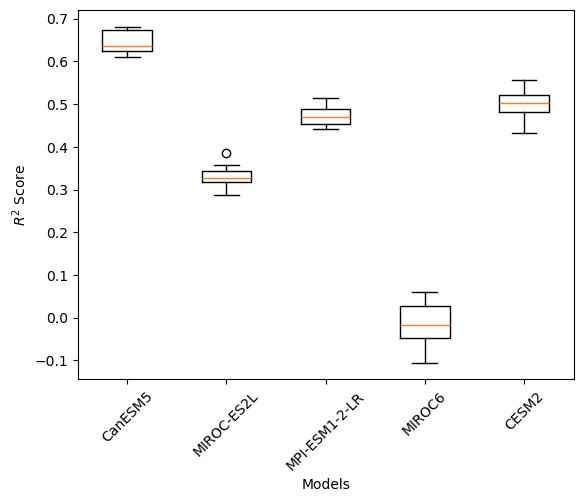

In [21]:
plt.boxplot([np.mean(scores_pattern[model][gamma], axis=1) for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_anchor{}_stability_coarse{}.pdf".format(gamma, coarse), format="pdf", bbox_inches="tight")

plt.show()

In [17]:
model = 'MPI-ESM1-2-LR'
scores_pattern_maps = np.mean(scores_pattern[model][gamma], axis=0).reshape(len(lat), len(lon))

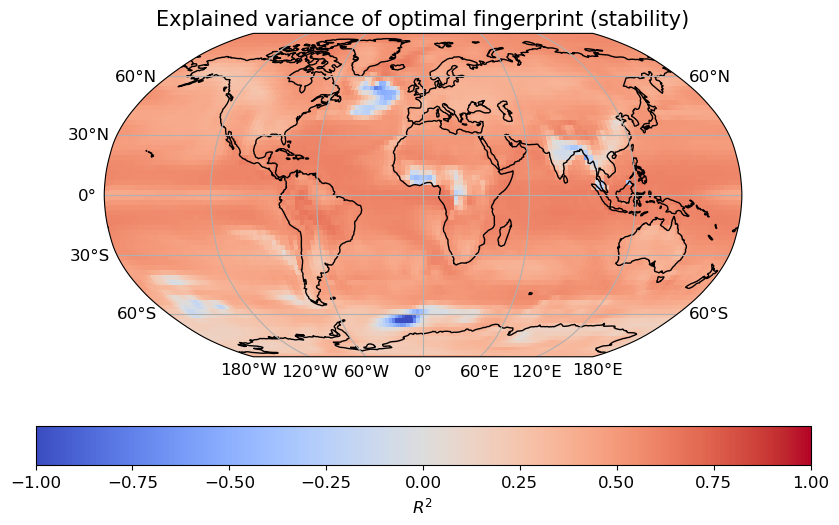

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_anchor{}_stability_coarse_{}_{}.pdf".format(gamma, coarse, model), format="pdf", bbox_inches="tight")


plt.show()